In [23]:
import torchmetrics

# 데이터 불러오는 함수
import os

import cv2          # 패키지 없음. Terminal에서 pip install opencv-python
import math


def get_data(data_dir, width=224, height=224):
    classes = os.listdir(data_dir)
    classes = [c for c in classes if os.path.isdir(os.path.join(data_dir, c))]
    assert len(classes) > 0
    data = {c: list() for c in classes}

    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        for file in os.listdir(cls_dir):
            image = cv2.imread(os.path.join(cls_dir, file))
            if image is None:
                print("[W] Failed to load image: {}".format(file))
                continue

            img_h, img_w = image.shape[:2]
            if (img_h / height) > (img_w / width):
                new_w = width
                new_h = math.ceil(img_h / img_w * new_w)
            else:
                new_h = height
                new_w = math.ceil(img_w / img_h * new_h)

            image = cv2.resize(image, (new_w, new_h))
            if new_w > new_h:
                diff = new_w - new_h
                left = diff // 2
                right = diff - left
                image = image[:, left:-right]
            elif new_h > new_w:
                diff = new_h - new_w
                left = diff // 2
                right = diff - left
                image = image[left:-right, :]

            data[cls].append(image)

    return data

# 데이터 불러오기
data_names = [
    "bonggae",
    "dosim",
    "gimnyeong",
    "jabaebong",
    "jogeun",
    "jongdal",
]
data_name = data_names[5]
data_dir = f"/mnt/raid/jwa/data/image/{data_name}"
data = get_data(data_dir, 512, 512)
print(f"Loaded data with {len(data)} classes.")


Loaded data with 36 classes.


# 모델 코드

In [24]:
from torchmetrics import ConfusionMatrix
import gc
import multiprocessing
import os
import random
import re
import traceback

import torch
from torchmetrics.functional.classification import multiclass_accuracy
from tqdm import tqdm


def preprocess_blip_input_text(text, max_words=50):
    text = re.sub(
        r"([.!\"()*#:;~])",
        " ",
        text.lower(),
    )
    text = re.sub(
        r"\s{2,}",
        " ",
        text,
    )
    text = text.rstrip("\n")
    text = text.strip(" ")

    # truncate caption
    caption_words = text.split(" ")
    if len(caption_words) > max_words:
        text = " ".join(caption_words[: max_words])

    return text


def get_scores_zero_shot(data, model_str, method_str, result_q=None):
    from transformers import AutoProcessor, AutoModel

    model = AutoModel.from_pretrained(model_str)
    processor = AutoProcessor.from_pretrained(model_str)

    model = model.cuda()  # gpu 사용할 때 쓰는 코드

    idx2cls = list(sorted(data.keys()))
    cls2idx = {c:i for i, c in enumerate(idx2cls)}

    img_and_label = []
    for cls, images in data.items():
        img_and_label.extend([(img, cls) for img in images])

    classes_ko = []
    classes_en = []
    for cls in idx2cls:
        idx = cls.index('(')
        ko = cls[:idx-1]
        en = cls[idx+1:-1]
        classes_ko.append(ko)
        classes_en.append(en)

    label_ids = [cls2idx[cls] for img, cls in img_and_label]
    label_ids = torch.tensor(label_ids)

    if method_str == "en":
        classes = classes_en
    elif method_str == "ko":
        classes = classes_ko
    elif method_str == "en_ko":
        classes = [f"{e} ({k})" for e, k in zip(classes_en, classes_ko)]
    elif method_str == "en_ko_prompt":
        classes = [f"{e} (known as '{k}' in Korean)." for e, k in zip(classes_en, classes_ko)]
    elif method_str == "en_prompt":
        classes = [f"This is a photo of '{c}'." for c in classes_en]
    else:
        raise NotImplementedError(method_str)

    inputs_kwargs = {
        "text": classes,
        # "images": [img for img, cls in img_and_label],
        "return_tensors": "pt",
        "padding": True,
        "truncation": True,
    }

    if model_str.find("google/siglip-") >= 0:
        inputs_kwargs["padding"] = "max_length"
    elif model_str.find("google/siglip2-") >= 0:
        inputs_kwargs["padding"] = "max_length"
        inputs_kwargs["max_length"] = 64
    elif model_str.find("Salesforce/blip-") >= 0:
        inputs_kwargs["text"] = [preprocess_blip_input_text(t) for t in inputs_kwargs["text"]]

    print(inputs_kwargs)
    inputs_kwargs["images"] = [img for img, cls in img_and_label]

    inputs = processor(**inputs_kwargs)
    all_img_inputs = inputs.data["pixel_values"]
    predictions = []
    batch_size = 1
    with tqdm(total=all_img_inputs.shape[0]) as pbar:
        for start in range(0, all_img_inputs.shape[0], batch_size):
            end = min(start + batch_size, all_img_inputs.shape[0])
            inputs.data["pixel_values"] = all_img_inputs[start:end]
            inputs = inputs.to(model.device)

            outputs = model(**inputs)
            pred = outputs.logits_per_image.argmax(dim=-1)
            predictions.append(pred)

            pbar.update(batch_size)

    predictions = torch.cat(predictions, dim=0)
    predictions = predictions.cpu()

    macro_accuracy = multiclass_accuracy(predictions, label_ids, len(idx2cls), average='macro')
    micro_accuracy = multiclass_accuracy(predictions, label_ids, len(idx2cls), average='micro')
    per_class_accuracy = multiclass_accuracy(predictions, label_ids, len(idx2cls), average='none')

    confmat = ConfusionMatrix(task="multiclass", num_classes=len(idx2cls))
    confmat(predictions, label_ids)

    scores = {
        "macro": macro_accuracy.cpu().item(),
        "micro": micro_accuracy.cpu().item(),
        "per_class": per_class_accuracy.cpu().tolist(),
        "conf_mat": confmat,
    }

    if result_q is not None:
        result_q.put(scores)

    return scores

In [25]:

exp_names = [
    "en",
    "ko",
    "en_ko",
    "en_ko_prompt",
    "en_prompt",
]

exp_name = exp_names[0]
# data_dir = f"/Users/jwa/Desktop/{data_name}"          # 데이터 위치
# output_dir = f"/content/out_dir/esac/{exp_name}"      # 원본 위치
output_dir = f"/mnt/raid/jwa/out/esac/{exp_name}"        # 수정 위치
os.makedirs(output_dir, exist_ok=True)

small_model_list = [
    "openai/clip-vit-base-patch16",
    "openai/clip-vit-base-patch32",
    "openai/clip-vit-large-patch14",
    "openai/clip-vit-large-patch14-336",

    "google/siglip-so400m-patch14-224",
    "google/siglip-base-patch16-256",
    "google/siglip-base-patch16-384",
    "google/siglip-base-patch16-512",
    "google/siglip-base-patch16-256-multilingual",
    "google/siglip-base-patch16-224",

    "google/siglip2-base-patch16-512",
    "google/siglip2-base-patch16-384",
    "google/siglip2-base-patch16-256",
    "google/siglip2-base-patch16-224",
    "google/siglip2-base-patch32-256",
]

model_str = small_model_list[4]
print(f"Running {model_str}")
scores = get_scores_zero_shot(data, model_str, exp_name)

print(f"Macro accuracy: {scores['macro']:.4f}, micro accuracy: {scores['micro']:.4f}")

Running google/siglip-so400m-patch14-224
{'text': ['Gracilaria parvispora I.A.Abbott, 1985', 'Champia inkyua Y.H.Koh, G.Y.Cho & M.S.Kim 2013', 'Plocamium uncinatum (C. Agardh) Kutzing, 1866', 'Ecklonia cava Kjellman, 1885', 'Pachymeniopsis lanceolata (K. Okamura) Y. Yamada ex S. Kawabata 1954', 'Pterocladiella capillacea', 'Sargassum filicinum Harvey 1860', 'Ulva australis Areschoug 1854', 'Dictyota dichotoma (Hudson) Lamouroux 1809', 'Gracilaria vermiculophylla (Ohmi) Papenfuss 1967', 'Grateloupia imbricata Holmes 1896', 'Grateloupia jejuensis S.Y. Kim, E.G. Han & S.M. Boo 2013', 'Chondracanthus tenellus (Harvey) Hommersand in Hommersand, Guiry, Fredericq & Leister 1993', 'Fushitsunagia catenata (Harvey) Filloramo & G.W.Saunders, 2016', 'Petalonia binghamiae (J. Agardh) K.L. Vinogradova 1973', 'Myelophycus simplex (Harvey) Papenfuss 1967', 'Petrospongium rugosum (Okamura) Setchell & Gardner 1924', 'Padina arborescens Holmes 1896', 'Grateloupia angusta (Okamura) S. Kawagu & H.W. Wang i

100%|██████████| 38/38 [00:05<00:00,  7.16it/s]


Macro accuracy: 0.1667, micro accuracy: 0.1579


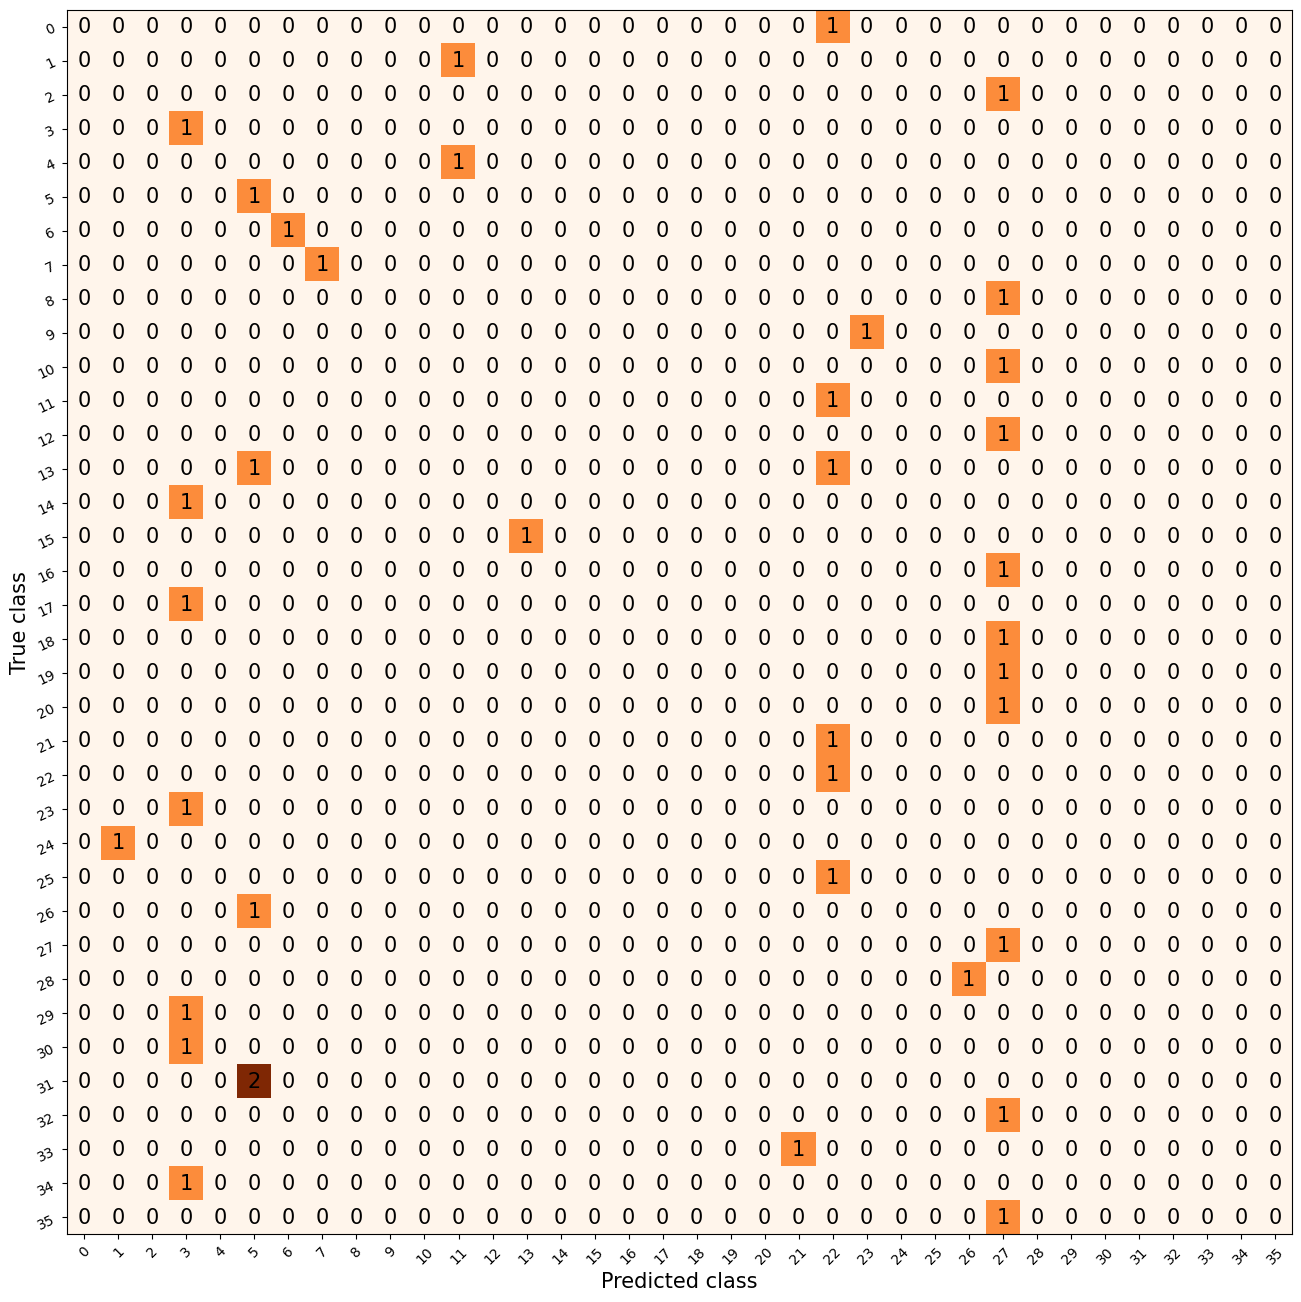

0: 각시꼬시래기 (Gracilaria parvispora I.A.Abbott, 1985)
1: 갈고리사슬풀 (Champia inkyua Y.H.Koh, G.Y.Cho & M.S.Kim 2013)
2: 갈고리참곱슬이 (Plocamium uncinatum (C. Agardh) Kutzing, 1866)
3: 감태 (Ecklonia cava Kjellman, 1885)
4: 개도박 (Pachymeniopsis lanceolata (K. Okamura) Y. Yamada ex S. Kawabata 1954)
5: 개우무 (Pterocladiella capillacea)
6: 고사리모자반 (Sargassum filicinum Harvey 1860)
7: 구멍갈파래 (Ulva australis Areschoug 1854)
8: 그물바탕말 (Dictyota dichotoma (Hudson) Lamouroux 1809)
9: 꼬시래기 (Gracilaria vermiculophylla (Ohmi) Papenfuss 1967)
10: 꽃지누아리 (Grateloupia imbricata Holmes 1896)
11: 댓잎도박 (Grateloupia jejuensis S.Y. Kim, E.G. Han & S.M. Boo 2013)
12: 돌가사리 (Chondracanthus tenellus (Harvey) Hommersand in Hommersand, Guiry, Fredericq & Leister 1993)
13: 마디잘록이 (Fushitsunagia catenata (Harvey) Filloramo & G.W.Saunders, 2016)
14: 미역쇠 (Petalonia binghamiae (J. Agardh) K.L. Vinogradova 1973)
15: 바위수염 (Myelophycus simplex 

In [26]:
# confusion matrix # 종달
import matplotlib.pyplot as plt

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

fig, ax = scores["conf_mat"].plot(cmap="Oranges")   # https://matplotlib.org/stable/users/explain/colors/colormaps.html
set_size(10, 10, ax)

plt.show()
idx2cls = list(sorted(data.keys()))
for i, cls in enumerate(idx2cls):
    print(f"{i}: {cls}")

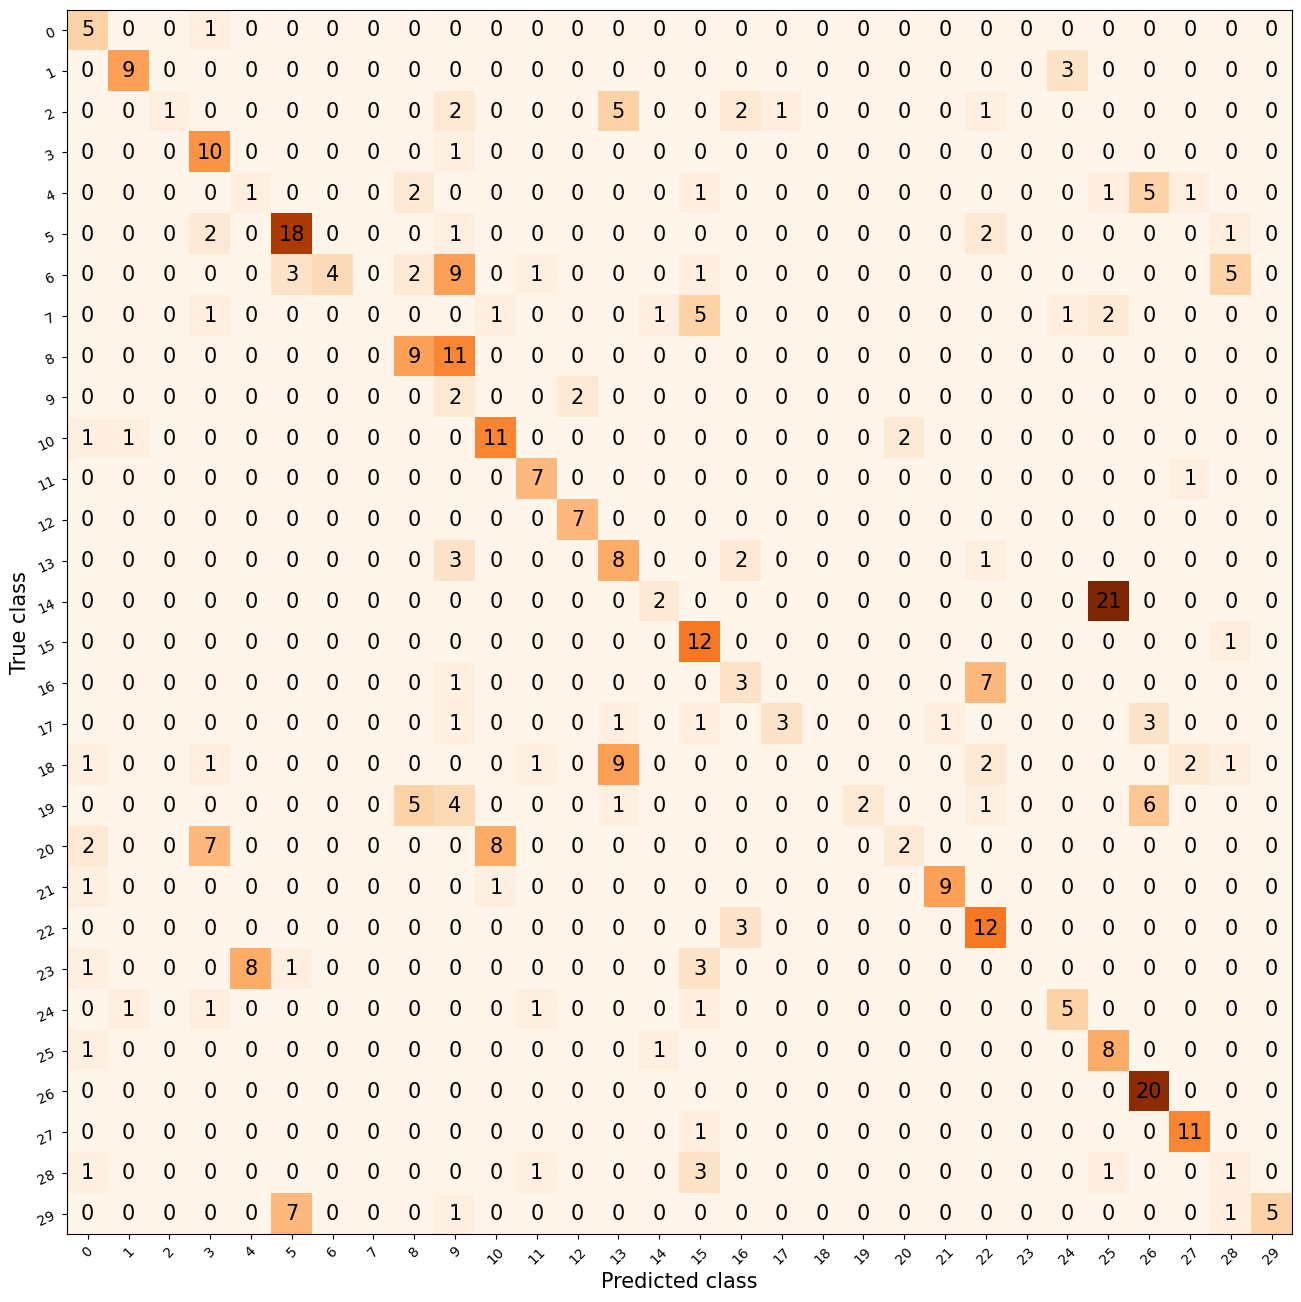

0: 거지덩굴 (Cayratia japonica (Thunb.) Gagnep.)
1: 까마귀쪽나무 (Litsea japonica (Thunb.) Juss.)
2: 깨풀 (Acalypha australis L.)
3: 누리장나무 (Clerodendrum trichotomum Thunb.)
4: 단풍마 (Dioscorea quinquelobata Thunb.)
5: 닭의장풀 (Commelina communis L.)
6: 대흥란 (Cymbidium macrorhizon Lindl.)
7: 말오줌때 (Euscaphis japonica (Thunb.) Kanitz)
8: 맥문동 (Liriope platyphylla F. T. Wang & T. Tang)
9: 무릇 (Barnardia japonica (Thunb.) Schult. & Schult. f.)
10: 백량금 (Ardisia crenata Sims)
11: 사위질빵 (Clematis apiifolia DC.)
12: 산꽃고사리 (Botrychium japonicum (Prantl) Underw.)
13: 산박하 (Isodon inflexus (Thunb.) Kudô)
14: 산초나무 (Zanthoxylum schinifolium Siebold & Zucc.)
15: 송악 (Hedera rhombea (Miq.) Bean)
16: 송장풀 (Leonurus macranthus Maxim.)
17: 쇠무릎 (Achyranthes bidentata var. japonica Miq.)
18: 수까치깨 (Corchoropsis tomentosa (Thunb.) Makino)
19: 이삭여뀌 (Persicaria filiformis (Thunb.) Nakai ex T. Mori)
20: 자금우 (Ardisia japonica 

In [22]:
# confusion matrix # 자배봉 식물
import matplotlib.pyplot as plt

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

fig, ax = scores["conf_mat"].plot(cmap="Oranges")   # https://matplotlib.org/stable/users/explain/colors/colormaps.html
set_size(10, 10, ax)

plt.show()
idx2cls = list(sorted(data.keys()))
for i, cls in enumerate(idx2cls):
    print(f"{i}: {cls}")

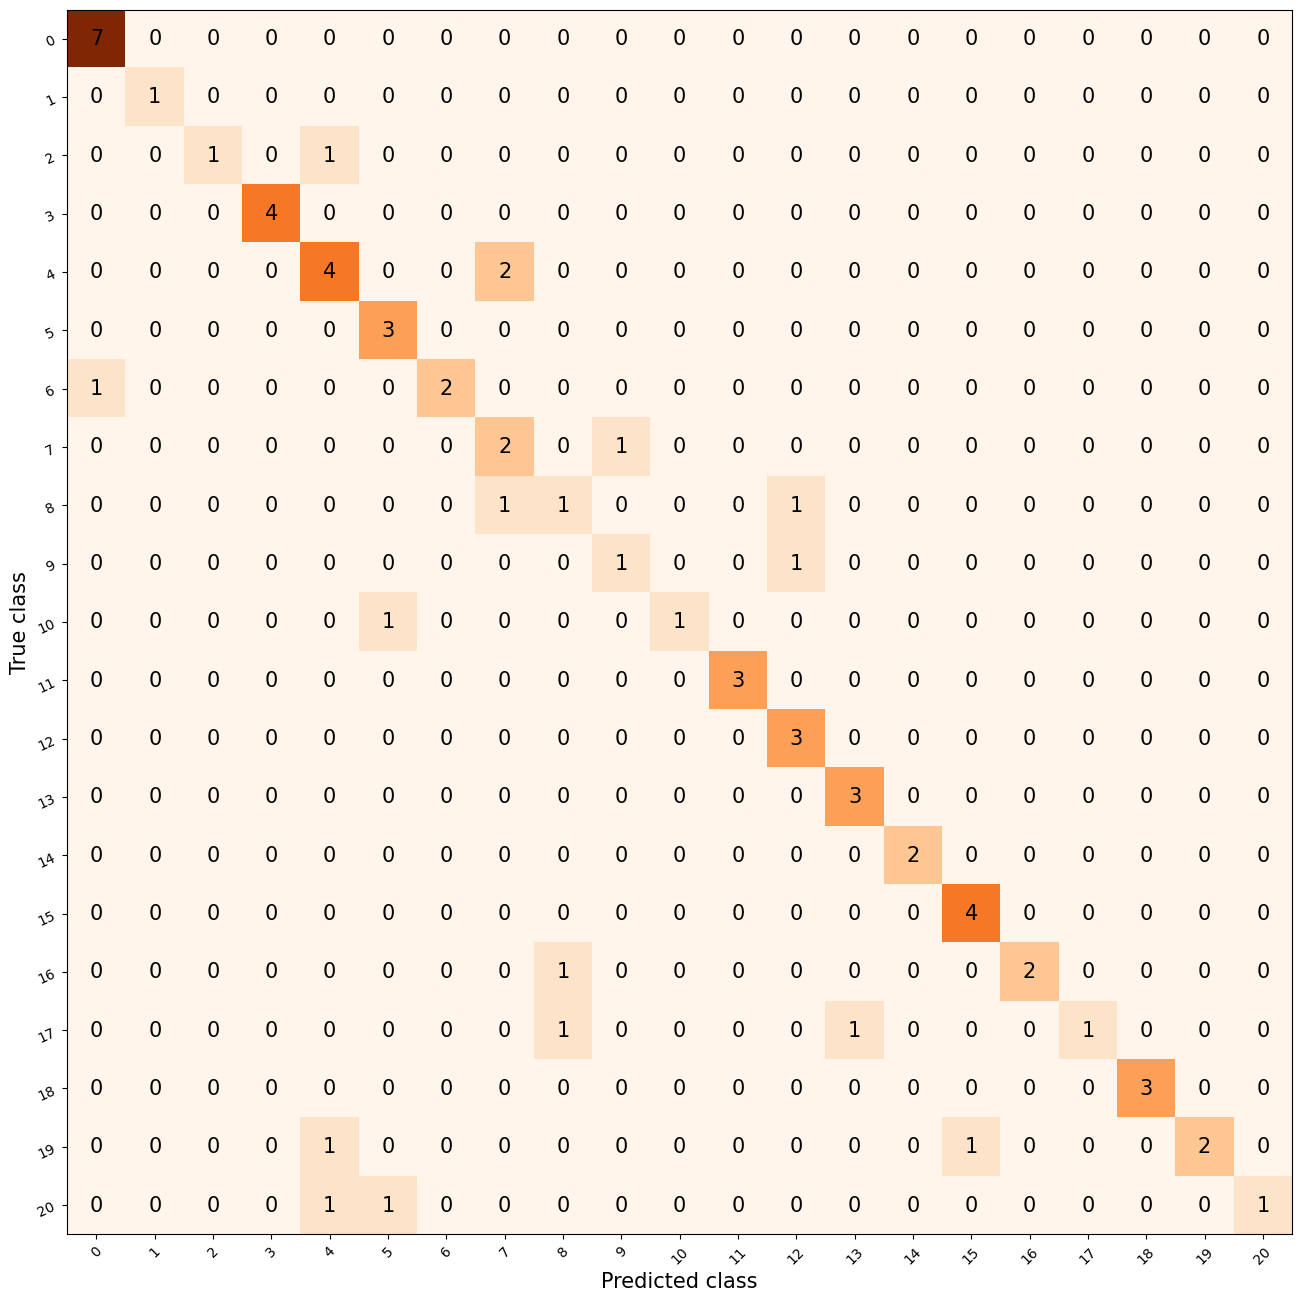

0: 갯강아지풀 (Setaria viridis var. pachystachys (Franch. & Sav.) Makino & Nemoto)
1: 갯강활 (Angelica japonica A. Gray)
2: 갯금불초 (Wedelia prostrata Hemsl.)
3: 갯기름나물 (Peucedanum japonicum Thunb.)
4: 갯까치수염 (Lysimachia mauritiana Lam.)
5: 갯메꽃 (Calystegia soldanella (L.) Roem. & Schult.)
6: 갯쑥부쟁이 (Aster hispidus Thunb.)
7: 갯질경 (Limonium tetragonum (Thunb.) Bullock)
8: 다닥냉이 (Lepidium apetalum Willd.)
9: 땅채송화 (Sedum oryzifolium Makino)
10: 모래냉이 (Diplotaxis muralis (L.) DC.)
11: 문주란 (Crinum asiaticum var. japonicum Baker)
12: 방석나물 (Suaeda australis (R. Br.) Moq.)
13: 번행초 (Tetragonia tetragonoides (Pall.) Kuntze)
14: 벌노랑이 (Lotus corniculatus var. japonicus Regel)
15: 순비기나무 (Vitex rotundifolia L. f.)
16: 애기달맞이 (Oenothera laciniata Hill)
17: 왕모시풀 (Boehmeria pannosa Nakai & Satake ex Oka)
18: 우묵사스레피 (Eurya emarginata (Thunb.) Makino)
19: 제주찔레 (Rosa lucieae Franch. & Rochebr. ex Cr

In [18]:
# confusion matrix # 김녕
import matplotlib.pyplot as plt

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

fig, ax = scores["conf_mat"].plot(cmap="Oranges")   # https://matplotlib.org/stable/users/explain/colors/colormaps.html
set_size(10, 10, ax)

plt.show()
idx2cls = list(sorted(data.keys()))
for i, cls in enumerate(idx2cls):
    print(f"{i}: {cls}")

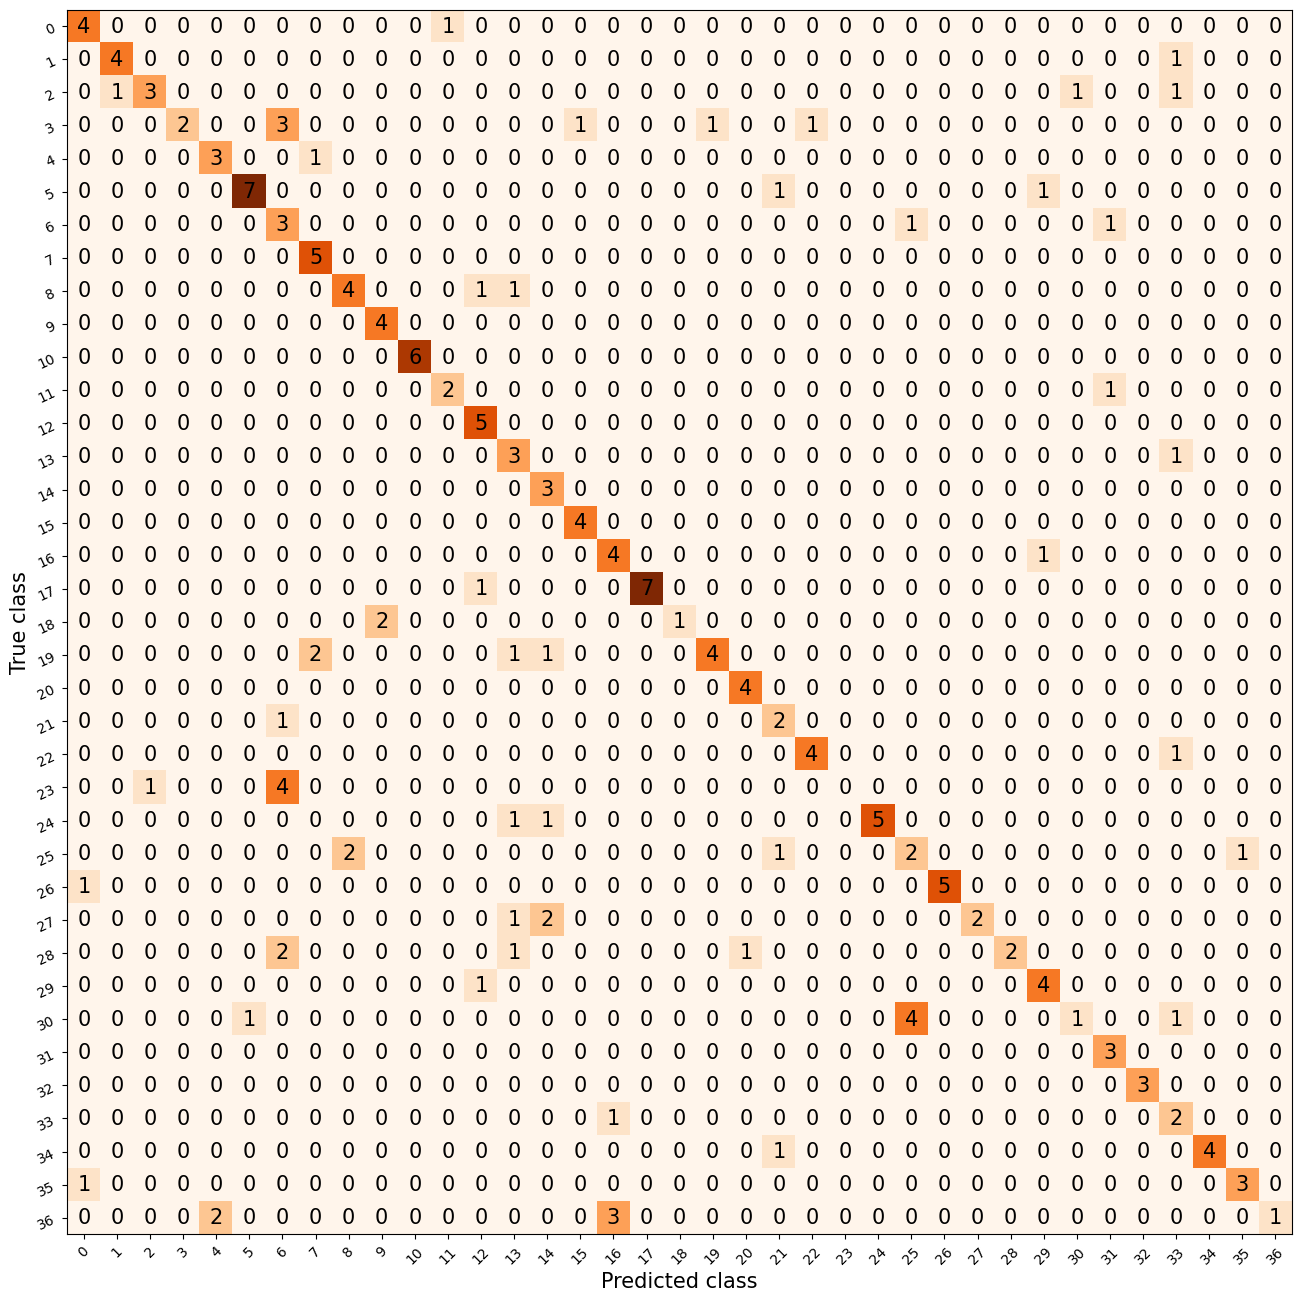

0: 강아지풀 (Setaria viridis (L.) P. Beauv.)
1: 개망초 (Erigeron annuus (L.) Pers.)
2: 개미자리 (Sagina japonica (Sw.) Ohwi)
3: 개여뀌 (Persicaria longiseta (Bruijn) Kitag.)
4: 거지덩굴 (Cayratia japonica (Thunb.) Gagnep.)
5: 광대나물 (Lamium amplexicaule L.)
6: 금창초 (Ajuga decumbens Thunb.)
7: 까마중 (Solanum nigrum L.)
8: 끈끈이대나물 (Silene armeria L.)
9: 냉이 (Capsella bursa-pastoris (L.) Medik.)
10: 달맞이꽃 (Oenothera biennis L.)
11: 닭의장풀 (Commelina communis L.)
12: 등갈퀴나물 (Vicia cracca L.)
13: 떡쑥 (Pseudognaphalium affine (D. Don) Anderb.)
14: 명아주 (Chenopodium album L.)
15: 미국자리공 (Phytolacca americana L. folder_special)
16: 미국쥐손이 (Geranium carolinianum L.)
17: 방동사니 (Cyperus amuricus Maxim.)
18: 방울새풀 (Briza minor (Ohwi) L.)
19: 쇠무릎 (Achyranthes bidentata var. japonica Miq.)
20: 쇠별꽃 (Stellaria aquatica (L.) Scop.)
21: 쇠비름 (Portulaca oleracea L.)
22: 시리아수수새 (Sorghum halepense (L.) Pers.)
23: 애기

In [13]:
# confusion matrix # 도심
import matplotlib.pyplot as plt

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

fig, ax = scores["conf_mat"].plot(cmap="Oranges")   # https://matplotlib.org/stable/users/explain/colors/colormaps.html
set_size(10, 10, ax)

plt.show()
idx2cls = list(sorted(data.keys()))
for i, cls in enumerate(idx2cls):
    print(f"{i}: {cls}")

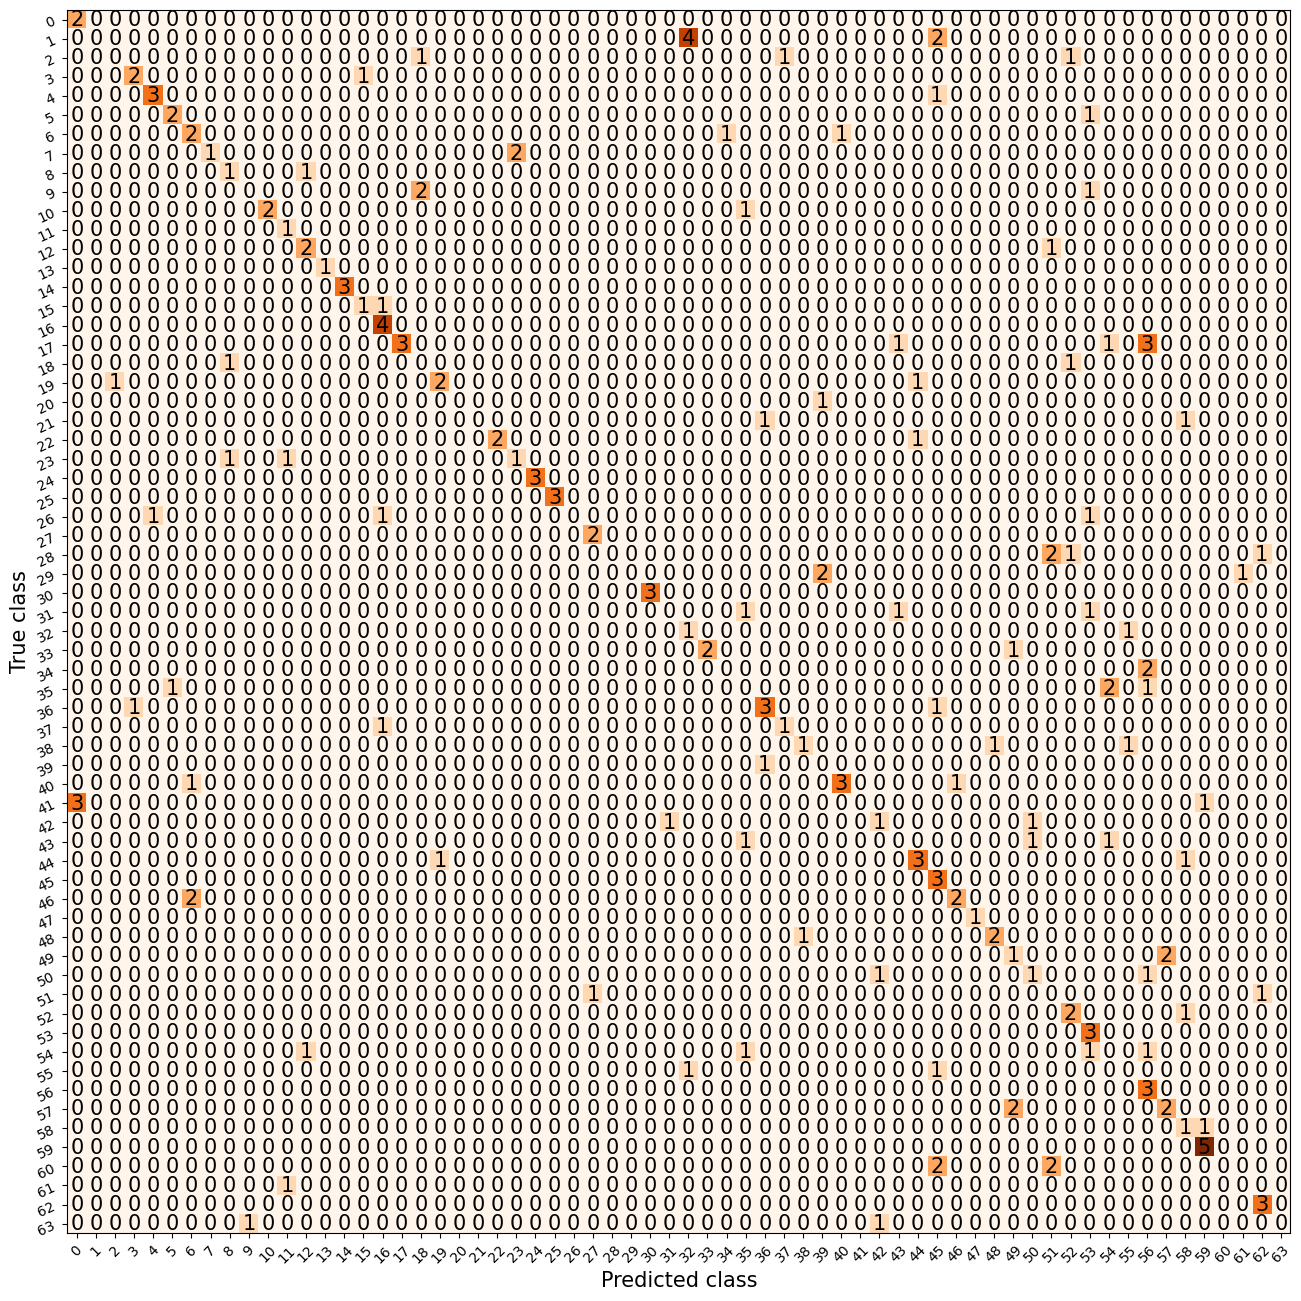

0: 갈매기난초 (Platanthera japonica (Thunb.) Lindl.)
1: 개감수 (Euphorbia sieboldiana Morren & Decne.)
2: 개머루 (Ampelopsis heterophylla (Thunb.) Siebold & Zucc.)
3: 개족도리풀 (Asarum maculatum Nakai)
4: 고로쇠나무 (Acer pictum subsp. mono (Maxim.) H.Ohashi)
5: 고추나무 (Staphylea bumalda DC.)
6: 관중 (Dryopteris crassirhizoma Nakai)
7: 국수나무 (Stephanandra incisa (Thunb.) Zabel)
8: 그늘별꽃 (Stellaria sessiliflora Y. Yabe)
9: 까마귀베개 (Rhamnella franguloides (Maxim.) Weberb.)
10: 까치박달 (Carpinus cordata Blume)
11: 나도고사리삼 (Ophioglossum vulgatum L.)
12: 누리장나무 (Clerodendrum trichotomum Thunb.)
13: 다래 (Actinidia arguta (Siebold & Zucc.) Planch. ex Miq.)
14: 단풍나무 (Acer palmatum Thunb.)
15: 단풍마 (Dioscorea quinquelobata Thunb.)
16: 댕댕이덩굴 (Cocculus orbiculatus (L.) DC.)
17: 덧나무 (Sambucus racemosa subsp. sieboldiana (Miq.) H. Hara)
18: 덩굴용담 (Tripterospermum japonicum (Siebold & Zucc.) Maxim.)
19: 돌외 (Gynostemma pentaphyllu

In [8]:

# confusion matrix # 봉개 민오름 식물
import matplotlib.pyplot as plt

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

fig, ax = scores["conf_mat"].plot(cmap="Oranges")   # https://matplotlib.org/stable/users/explain/colors/colormaps.html
set_size(10, 10, ax)

plt.show()
idx2cls = list(sorted(data.keys()))
for i, cls in enumerate(idx2cls):
    print(f"{i}: {cls}")